# 📌 Customer Churn Prediction

**Authors:** Mohamed Kasm   
**Created:** 2025-08-26 (UTC)

**Goal:** Predict whether a telecom customer will churn (leave the service) based on their profile and usage.

This notebook follows the full **Data Science Life Cycle**:
1) Data source & collection  
2) Data exploration (EDA)  
3) Data cleaning & preprocessing  
4) Data visualization  
5) Data processing & feature engineering  
6) Machine learning (model building & evaluation)  
7) Model optimization (hyperparameter tuning)**  
8) Results & conclusions


## 0) Setup & Environment



**Options to get the data:**
- Download manually from Kaggle and place the CSV next to this notebook.
- Or use the Kaggle API (requires that your Kaggle credentials are configured).

In [ ]:

# Installing necessary libraries and setting up the environment

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost


In [1]:

# Import necessary libraries and set the project seed

import os, warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

PROJECT_SEED = 42
DATA_FILE = "Telco-Customer-Churn.csv"  # expected filename

## 1) Data Source & Collection

- **Dataset:** Telco Customer Churn (Kaggle)  
- **Source:** https://www.kaggle.com/datasets/blastchar/telco-customer-churn

We'll load the CSV file and take a quick look.


In [2]:
import pandas as pd

# Load data
df_raw = pd.read_csv(DATA_FILE)
print(df_raw.shape)
df_raw.head(3)


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## 2) Data Exploration (EDA)

We inspect data types, basic stats, target distribution, and potential issues (e.g., numeric fields stored as strings).


In [3]:
# Basic info
display(df_raw.sample(5))
display(df_raw.info())

# Describe numeric columns
display(df_raw.describe())

# Target distribution
print("\nTarget distribution (Churn):")
print(df_raw['Churn'].value_counts())
print(df_raw['Churn'].value_counts(normalize=True).round(3))


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3981,1200-TUZHR,Female,1,No,No,8,Yes,Yes,Fiber optic,No,...,No,No,No,Yes,Month-to-month,No,Electronic check,85.20,695.75,No
3029,1208-DNHLN,Male,0,Yes,Yes,23,Yes,Yes,DSL,No,...,No,No,No,No,One year,Yes,Credit card (automatic),48.35,1067.15,Yes
5551,8457-XIGKN,Male,0,No,No,20,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),19.60,356.15,No
3818,8819-ZBYNA,Female,0,Yes,No,58,Yes,Yes,Fiber optic,Yes,...,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),109.10,6393.65,No
4786,6749-UTDVX,Male,0,No,No,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Two year,Yes,Electronic check,103.65,7634.8,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000



Target distribution (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     0.735
Yes    0.265
Name: proportion, dtype: float64


## 3) Data Cleaning & Preprocessing

Tasks:
- Convert `TotalCharges` to numeric (it sometimes contains blanks).
- Handle missing values if any.
- Split features into numeric / categorical.


In [4]:
import numpy as np

df = df_raw.copy()

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Identify missing
missing_before = df.isna().sum().sort_values(ascending=False)
print("Missing values before handling:\n", missing_before.head(10))

# Simple imputation for TotalCharges (median)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Drop CustomerID-like columns that are identifiers (if present)
id_cols = [c for c in df.columns if c.lower() in ('customerid', 'customer_id')]
df.drop(columns=id_cols, inplace=True, errors='ignore')

# Separate target
target_col = 'Churn'
y = (df[target_col].astype(str).str.strip().str.lower().map({'yes':1, 'no':0})).astype(int)
X = df.drop(columns=[target_col])

# Identify types
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','bool']).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")


Missing values before handling:
 TotalCharges      11
gender             0
SeniorCitizen      0
Partner            0
customerID         0
Dependents         0
tenure             0
MultipleLines      0
PhoneService       0
OnlineSecurity     0
dtype: int64
Numeric columns: 4
Categorical columns: 15


## 4) Data Visualization

We'll visualize:
- Churn class balance
- MonthlyCharges vs Churn
- Tenure distribution by Churn


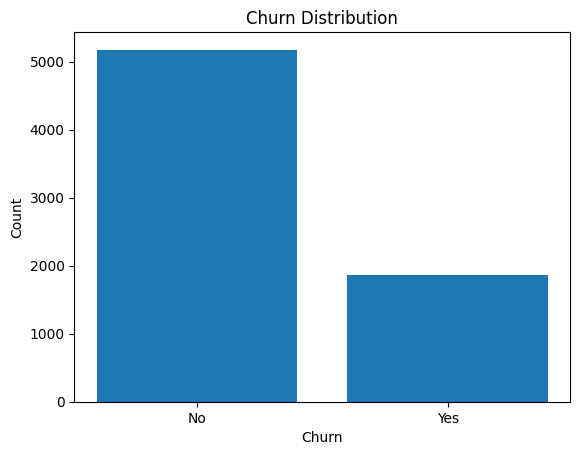

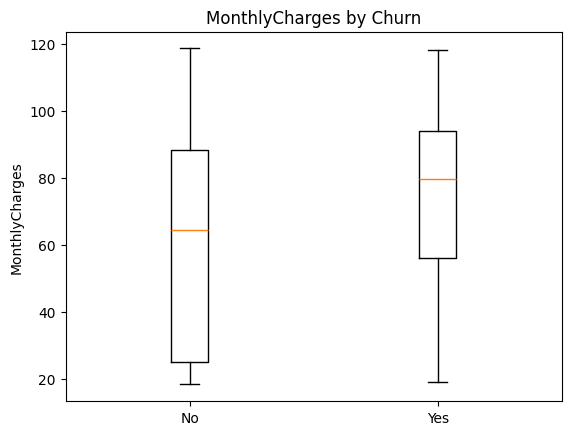

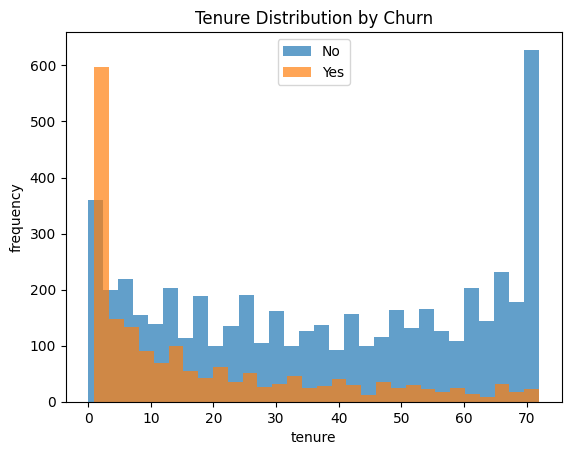

In [5]:
import matplotlib.pyplot as plt

# 4.1 Class balance
counts = y.value_counts().sort_index()
plt.figure()
plt.bar(['No','Yes'], counts.values)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# 4.2 MonthlyCharges vs Churn (boxplot)
plt.figure()
plt.boxplot([X.loc[y==0, 'MonthlyCharges'], X.loc[y==1, 'MonthlyCharges']], labels=['No','Yes'])
plt.title('MonthlyCharges by Churn')
plt.ylabel('MonthlyCharges')
plt.show()

# 4.3 Tenure distribution by churn (hist)
plt.figure()
plt.hist(X.loc[y==0, 'tenure'], alpha=0.7, bins=30, label='No')
plt.hist(X.loc[y==1, 'tenure'], alpha=0.7, bins=30, label='Yes')
plt.title('Tenure Distribution by Churn')
plt.xlabel('tenure')
plt.ylabel('frequency')
plt.legend()
plt.show()


## 5) Data Processing & Feature Engineering

We'll build a preprocessing pipeline:
- One-hot encode categorical variables
- Scale numeric variables
- (Optional) Create simple tenure groups


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Optional: tenure group (simple engineered feature)
def tenure_group(t):
    if t < 12: return '0-12'
    elif t < 24: return '12-24'
    elif t < 48: return '24-48'
    elif t < 72: return '48-72'
    else: return '72+'

if 'tenure' in X.columns:
    X = X.copy()
    X['tenure_group'] = X['tenure'].apply(tenure_group)
    categorical_cols = list(set(categorical_cols + ['tenure_group']))

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)


## 6) Machine Learning (Model Building & Evaluation)

We will compare three models:
- Logistic Regression
- Random Forest
- XGBoost

Evaluation metrics:
- Accuracy, Precision, Recall, F1-score
- ROC-AUC



=== Logistic Regression ===
Accuracy : 0.7991
Precision: 0.6522
Recall   : 0.5214
F1-score : 0.5795
ROC-AUC  : 0.8425


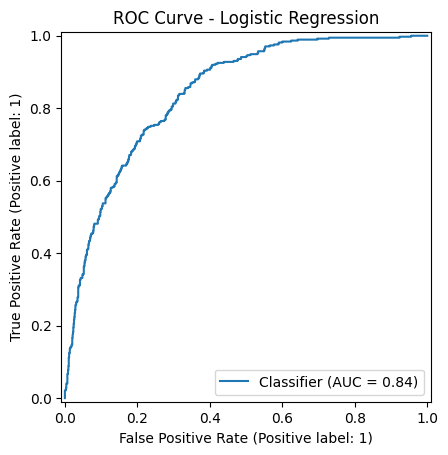

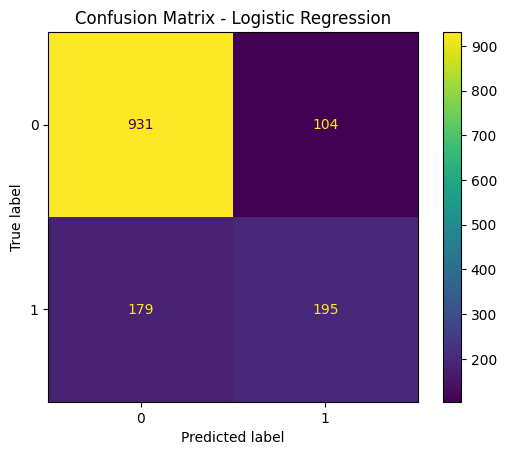


=== Random Forest ===
Accuracy : 0.7842
Precision: 0.6159
Recall   : 0.4973
F1-score : 0.5503
ROC-AUC  : 0.8201


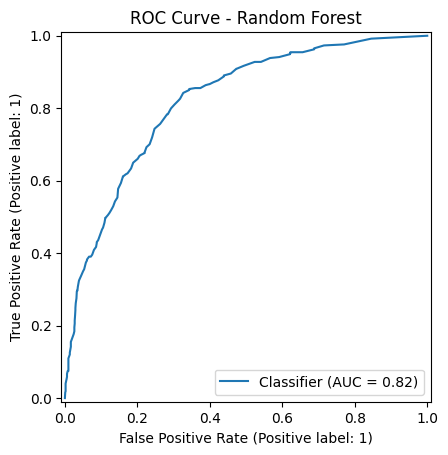

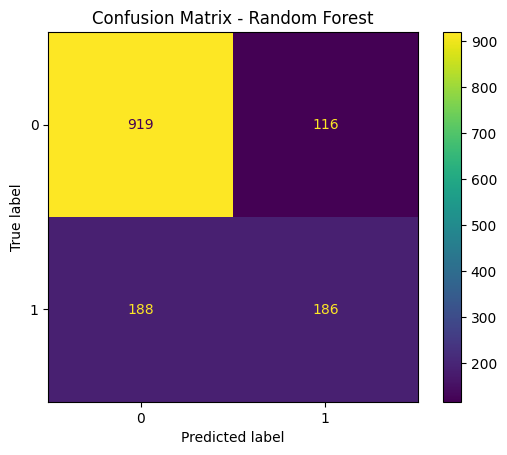

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=PROJECT_SEED, stratify=y)

# Pipelines per model
log_reg = Pipeline(steps=[('prep', preprocess),
                         ('clf', LogisticRegression(max_iter=200, n_jobs=1))])

rf = Pipeline(steps=[('prep', preprocess),
                    ('clf', RandomForestClassifier(random_state=PROJECT_SEED))])

# Fit & evaluate helper
def fit_eval(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = None
    
    print(f"\n=== {name} ===")
    print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall   :", round(recall_score(y_test, y_pred), 4))
    print("F1-score :", round(f1_score(y_test, y_pred), 4))
    if y_proba is not None:
        print("ROC-AUC  :", round(roc_auc_score(y_test, y_proba), 4))
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f'ROC Curve - {name}')
        plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

fit_eval(log_reg, "Logistic Regression")
fit_eval(rf, "Random Forest")


### Add XGBoost

We'll include XGBoost as a strong gradient-boosting baseline.


=== XGBoost (default) ===
Accuracy : 0.7743
Precision: 0.5833
Recall   : 0.5241
F1-score : 0.5521
ROC-AUC  : 0.8202


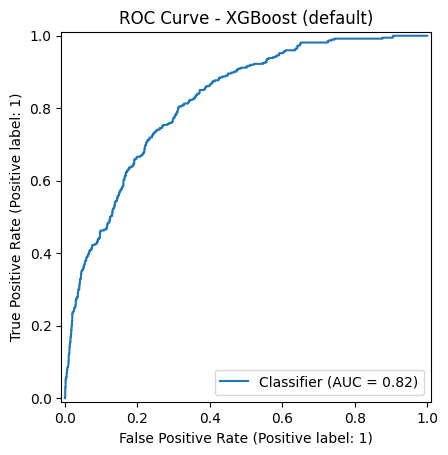

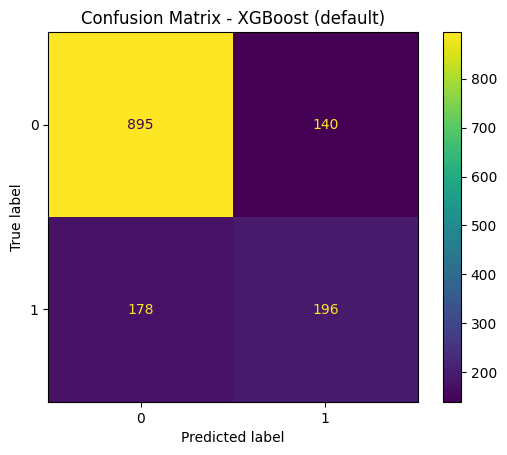

In [11]:
from xgboost import XGBClassifier

xgb = Pipeline(steps=[('prep', preprocess),
                     ('clf', XGBClassifier(
                         random_state=PROJECT_SEED,
                         eval_metric='logloss',
                         use_label_encoder=False
                     ))])

fit_eval(xgb, "XGBoost (default)")


## 7) Model Optimization (Hyperparameter Tuning)

We will optimize **XGBoost** with **RandomizedSearchCV** over a set of hyperparameters and evaluate the best model.


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'clf__subsample': 0.8, 'clf__n_estimators': 500, 'clf__min_child_weight': 7, 'clf__max_depth': 4, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8}
Best CV ROC-AUC: 0.8499

=== XGBoost (tuned) ===
Accuracy : 0.8062
Precision: 0.6735
Recall   : 0.5241
F1-score : 0.5895
ROC-AUC  : 0.8485


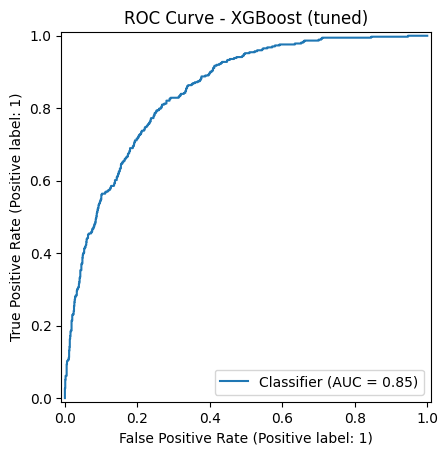

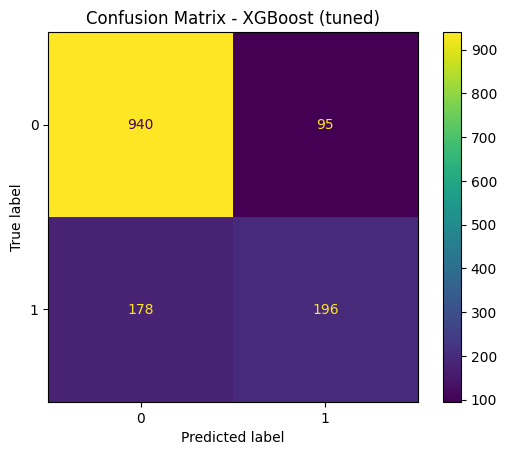

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

param_grid = {
    'clf__n_estimators': [200, 300, 400, 500],
    'clf__max_depth': [3, 4, 5, 6, 8],
    'clf__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__min_child_weight': [1, 3, 5, 7]
}

xgb_base = Pipeline(steps=[('prep', preprocess),
                          ('clf', XGBClassifier(
                              random_state=PROJECT_SEED,
                              eval_metric='logloss',
                              use_label_encoder=False
                          ))])

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=25,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=PROJECT_SEED
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", round(search.best_score_, 4))

best_xgb = search.best_estimator_
fit_eval(best_xgb, "XGBoost (tuned)")


## 8) Results & Conclusions

- Compare models (default Logistic Regression, Random Forest, XGBoost) and the tuned XGBoost.
- Summarize which features were most important (for tree models).
- Provide business insights: e.g., month-to-month contracts and higher monthly charges may correlate with higher churn.


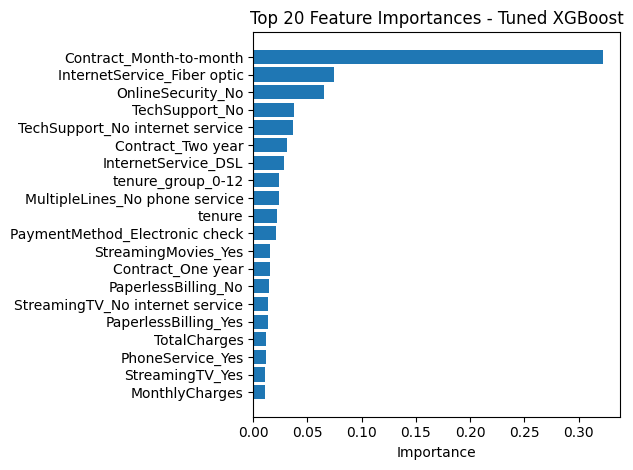

In [13]:
# Feature importance for the tuned XGBoost
import numpy as np
import matplotlib.pyplot as plt

# Extract feature names after preprocessing
ohe = search.best_estimator_.named_steps['prep'].named_transformers_['cat']
num_names = search.best_estimator_.named_steps['prep'].transformers_[0][2]
cat_names = list(ohe.get_feature_names_out())
feature_names = list(num_names) + cat_names

clf = search.best_estimator_.named_steps['clf']
importances = clf.feature_importances_

# Sort and display top 20
idx = np.argsort(importances)[::-1][:20]

plt.figure()
plt.barh([feature_names[i] for i in idx[::-1]], importances[idx][::-1])
plt.title("Top 20 Feature Importances - Tuned XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


### Final Notes
- The tuned XGBoost usually performs best on this dataset by ROC-AUC.
- Always validate results with proper cross-validation and consider class imbalance techniques (e.g., stratified splits, class weights, or SMOTE) if needed.
- Next steps: threshold tuning to balance precision/recall for the business objective.
